# *SARGASSUM* GROWTH DURING TRANSPORT 

This notebook guides you through the process of modelling growth of *Sargassum* rafts during transport in the Atlantic Ocean. The aim of this project was to create a customizable *Sargassum* growth model to be included in Lagrangian simulations using **Parcels**. Customizability is essential as emperical studies report varying maximal growth rates and types of physicochemical limitations. Additionally, three genotypes of *Sargassum* exist in Atlantic Ocean which seem to behave differently. Variables as maximum growth rate and optimal temperature can therefore be easily adapted in this growth model. The notebook is build up by the following steps:
- Defining the limitation functions on growth by physico-chemical factors
- Creating a map of Sargassum locations based on satellite detections from the Sargassum Watch System (SaWS)
- Combining all the required data fields for *Sargassum* simulation as a fieldset
- Defining *Sargassum* rafts as particles for a simulation with related characteristic variables
- Setting up the operational kernels to describe *Sargassum* behaviour
- Executing the simulation
- Visualizing the output

We start by importing the relevant packages.


In [1]:
#Importing relevent packages
import parcels
import math
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature
import cmocean.cm as cmo
from datetime import datetime, timedelta

## Defining the limitation functions on growth by physico-chemical factors

The growth of _Sargassum_ is known to be limited by for example oceanic conditions and nutrient availability. Some of the most important factors limiting Sargassum growth are temperature, salinity and nitrogen availability. The reducing effect on growth by these factors implemented in this model as **growth factors**, ranging between 0 (meaning no growth and maximum limitation) and 1 (meaning maximum growth and no limitation). A lot of uncertainty remains about the exact dependencies of Sargassum on these parameters. Tweeking these model parameters can alter the change in biomass.

In [ ]:
#RATES
maximum_growth_rate = 0.095 #doublings/day (Magana-Gallegos et al., 2023)
mortality_rate = 0.025      #relative loss/day

#Minimum, maximum and optimal temperature 
T_min = 20      #degC (Jouanno et al., 2025)
T_max = 31      #degC (Jouanno et al., 2025)
T_opt = 27.5    #degC (Jouanno et al., 2025)

#Nitrogen half saturation constant
k_N  = 0.001 #mmol/m3

#Optimal salinity
S_opt = 36 #psu (Jouanno et al., 2025)

The figure below visualizes the dependencies of Sargassum growth on the various physico-chemical factors, which are determined by the model paramters selected in the previous cell.

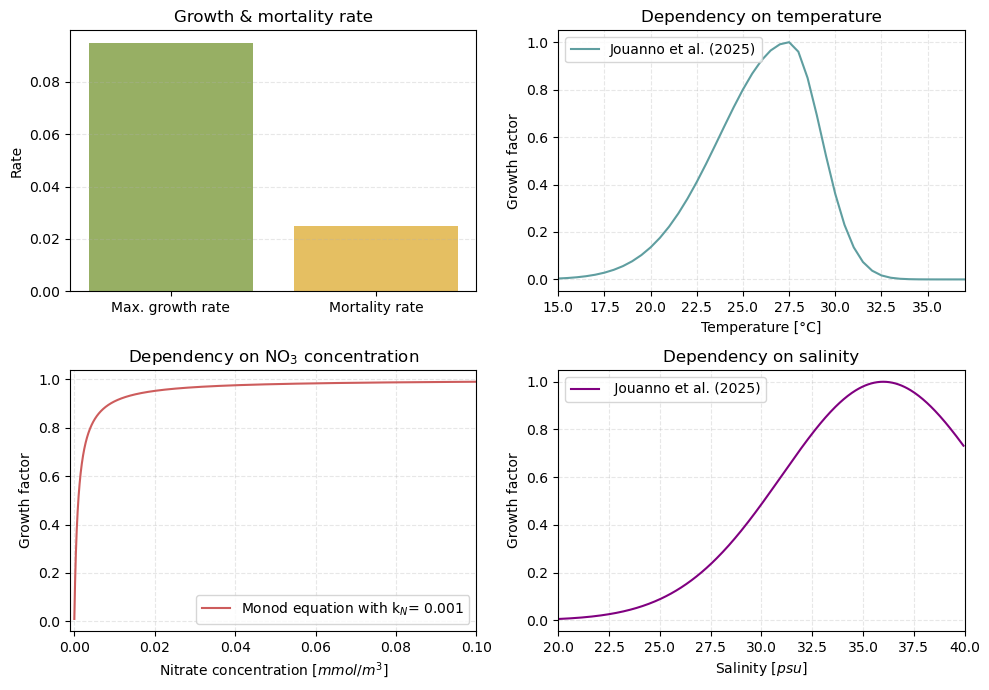

In [3]:
#Variable initialization
T = np.arange(14,38,0.5)
N = np.arange(0.00001,0.1,0.00001)
S = np.arange(20,40,0.05)

#Growth factor curves
T_x = np.full_like(T,T_min)    
T_x[T > T_opt] = T_max          
growth_factor_T = np.exp(-2 * ((T - T_opt) /(T_x - T_opt))**2 )
growth_factor_N = N / (N + k_N)
growth_factor_S = np.exp(-0.02 * (S_opt - S)**2)

#Figure
fig_growthcurves, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 7))

#Growth rate & mortality rate
rates = [maximum_growth_rate, mortality_rate]
labels = ['Max. growth rate', 'Mortality rate']
ax1.bar(labels, rates, color=['olivedrab', 'goldenrod'], alpha=0.7)
ax1.set_ylabel('Rate')
ax1.set_title('Growth & mortality rate')
ax1.grid(alpha=0.3, linestyle='--', axis='y')

#Temperature
ax2.plot(T, growth_factor_T, label=f'Jouanno et al. (2025)', c = 'cadetblue')
ax2.set_xlabel('Temperature [°C]')
ax2.set_ylabel('Growth factor')
ax2.set_title('Dependency on temperature')
ax2.grid(alpha=0.3, linestyle='--')
ax2.legend(loc='upper left')
ax2.set_xlim(15,37)

#Nitrogen concentration
ax3.plot(N, growth_factor_N, label = f'Monod equation with k$_N$= {k_N}', color='indianred')
ax3.set_xlabel('Nitrate concentration [$mmol / m^3$]')
ax3.set_ylabel('Growth factor')
ax3.set_title(f'Dependency on NO$_3$ concentration')
ax3.legend(loc='lower right')
ax3.grid(alpha=0.3, linestyle='--')
ax3.set_xlim(-0.001,0.1)

#Salinity concentration
ax4.plot(S, growth_factor_S, label = f' Jouanno et al. (2025)', color='purple')
ax4.set_xlabel('Salinity [$psu$]')
ax4.set_ylabel('Growth factor')
ax4.set_title(f'Dependency on salinity' )
ax4.legend()
ax4.grid(alpha=0.3, linestyle='--')
ax4.set_xlim(20,40)

plt.tight_layout()
plt.show()

## Creating a map of *Sargassum* locations based on satellite detections


To initialize Sargassum particles at locations where actual Sargassum has been detected, we use satellite images of the Sargassum Watch System (SaWS) of the University of South-Florida.  We use the composite FA-UNET-DENSITY-7DAY images, which show the floating algae (FA) density, in terms of percentage of area cover. A value of 0.1 on the color bar indicates 0.1\% surface area coverage by floating algae in that location. The FA density is calculated as a mean of the 7 past days, and is based on the U-Net method described by Hu et al. (2023). The function in the following cell was created to create a Sargassum release grid based on these SaWS satellite images.

In [4]:
def sarg_grid_from_sat(image_name, north, south, east, west, coarse=False):

    #Loading the image as an RGB array
    from PIL import Image
    img = Image.open(image_name).convert("RGB")
    img_array = np.array(img)

    #Computing brightness by approximating average or weighted sum of RGB
    brightness = img_array.mean(axis=2)

    #Creating a land mask based on the brown color of landmass
    r, g, b = img_array[:,:,0], img_array[:,:,1], img_array[:,:,2]

    #Brown tends to be dark, reddish, and not too saturated
    land_mask = (
        (r > 60) & (r < 160) &          # moderate red
        (g > 30) & (g < 110) &          # moderate green
        (b < 70) &                      # low blue
        (brightness < 120) &            # exclude bright oranges
        ((r - g) > 15) &                # red clearly higher than green
        ((r - b) > 40)                  # red much higher than blue
        )
    #Expanding land mask with binary_dilation method by 20 pixels (~20 km as 1 pixel ~ 1 km resolution)
    from scipy.ndimage import binary_dilation
    expanded_land_mask = binary_dilation(land_mask, iterations=20)

    #Setting threshold to get binary mask - set at 60 to include bright pixels and especially also red pixels
    threshold = 60
    binary_mask = (brightness > threshold).astype(int)

    #Applying the expaned land mask on binary mask
    binary_mask[expanded_land_mask] = 0

    #Creating coordinate grids based on bounding boxes
    height, width = binary_mask.shape
    lats = np.linspace(north, south, height)
    lons = np.linspace(west, east, width)

    #Creating 2D coordinate grids
    lon_grid, lat_grid = np.meshgrid(lons, lats)

    #Downsample with stride 2 (or other number) if you want to select less particles
    stride = 2 if coarse else 1
    mask = binary_mask[::stride, ::stride]
    lat = lat_grid[::stride, ::stride]
    lon = lon_grid[::stride, ::stride]

    amount = int(mask.sum())

    #Creating 2D grids of Sargassum release locations
    sarg_lon_grid = xr.DataArray(lon).where(mask == 1)
    sarg_lat_grid = xr.DataArray(lat).where(mask == 1)

    print('Shape of grid:', np.shape(sarg_lon_grid))

    #To prepare the grids as ParticleSet input, NaNs are removed and and arrays are ravelled (flattened)
    no_nan_mask = (~np.isnan(sarg_lon_grid)) & (~np.isnan(sarg_lat_grid)) 
    sarg_lon_grid = sarg_lon_grid.values[no_nan_mask].ravel()
    sarg_lat_grid = sarg_lat_grid.values[no_nan_mask].ravel()
    print('Reshaped grid as particle set:', np.shape(sarg_lon_grid))

    return sarg_lon_grid, sarg_lat_grid, amount

The SaWS data is split up in images with different regions. In this notebook, we focus on the Atlantic basin in July 2024 and therefore we use images from the Central and Central East Atlantic with the following coordinates (N, S, E, W):
- The Central Atlantic box is bounded by: 22.0, 0.0, -38.0, -63.0
- The Centrel East Atlantic box is bounded by: 22.0, 0.0, -11.5, -38.0

The images below will be used as input and show the two areas with composite data from 01-07-2024. Black pixels indicate that there is no data, at that location (mostly due to couds).

<p float="left">
  <img src="/nethome/6903894/testing/Input_data_test/C20241772024183.1KM.C_ATLANTIC.7DAY.L3D.FA_UNET_DENSITY.png" height="330" />
  <img src="/nethome/6903894/testing/Input_data_test/C20241772024183.1KM.CE_ATLANTIC.7DAY.L3D.FA_UNET_DENSITY.png" height="330" />
</p>


In the following piece of code, we load the images and apply the `sarg_grid_from_sat` function defined in the previous cell. Make sure the correct coordinates of the bounding boxes are selected. You can also choose if you want the grid to be `coarse`, so the simulation runs faster. Also, the grids are combined to be suitable as input for the `ParticleSet`, later in the notebook.

Shape of grid: (1210, 1375)
Reshaped grid as particle set: (92988,)
Shape of grid: (1210, 1458)
Reshaped grid as particle set: (10626,)


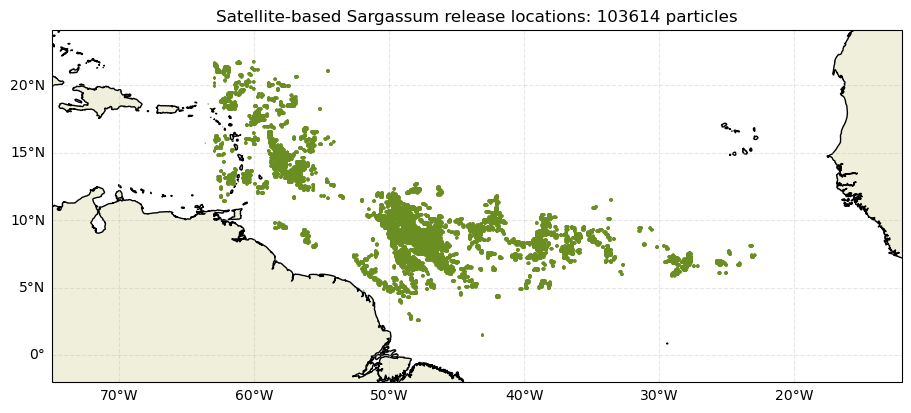

In [5]:
#Loading satellite images
image_name_Central_Atlantic = "/nethome/6903894/testing/Input_data_test/C20241772024183.1KM.C_ATLANTIC.7DAY.L3D.FA_UNET_DENSITY.png"
image_name_Central_East_Atlantic = "/nethome/6903894/testing/Input_data_test/C20241772024183.1KM.CE_ATLANTIC.7DAY.L3D.FA_UNET_DENSITY.png"

#Applying function on images
sarg_lon_grid_C, sarg_lat_grid_C, amount_C = sarg_grid_from_sat(image_name_Central_Atlantic, 22.0, 0.0, -38.0, -63.0, coarse=True)
sarg_lon_grid_CE, sarg_lat_grid_CE, amount_CE = sarg_grid_from_sat(image_name_Central_East_Atlantic, 22.0, 0.0, -11.5, -38.0, coarse=True)

#Adding the grids of both images to 1 longitude array and 1 latitude array and 1 amount
sarg_LONGITUDES = np.append(sarg_lon_grid_C, sarg_lon_grid_CE, axis=0)
sarg_LATITUDES  = np.append(sarg_lat_grid_C, sarg_lat_grid_CE, axis=0)
sarg_AMOUNT = amount_C + amount_CE

#Plotting to check the release locations
fig = plt.figure(figsize = (9,4), constrained_layout=True)
ax = plt.axes(projection=ccrs.PlateCarree(),zorder=4)
ax.add_feature(cartopy.feature.COASTLINE.with_scale('10m'),zorder=2)
ax.add_feature(cartopy.feature.LAND.with_scale('10m'), zorder=1)
ax.gridlines(draw_labels=['left','bottom'], zorder=0, alpha=0.3, linestyle='--')
ax.scatter(sarg_LONGITUDES, sarg_LATITUDES, s = 0.1, color='olivedrab', zorder=5)
ax.set_extent([-75,-12, -2,21])
ax.set_title(f'Satellite-based Sargassum release locations: {sarg_AMOUNT} particles')
plt.show()

## Combining all the required data fields for *Sargassum* simulation as a fieldset

To simulate Sargassum transport, we need to load all the data of the Atlantic Ocean domain as a `fieldset`. The following datasets and variables are required for the physical transport and growth model:
- **Physical transport** 
    - Current advection: `U` , `V`
    - Stokes drift: `U_wave_Stokes`, `V_wave_Stokes`, `wave_Tp`
    - Windage: `U_wind`, `V_wind`
- **Tracer fields**
    - Temperature: `T`
    - Salinity: `S`
    - Nitrate concentration: `no3`

First make sure the time-settings (corresponding to your satellite images) are correct. As default, duration of the simulations is set as 1 month to see the growth development. 

In [6]:
#SIMULATION TIME SETTINGS  
#Time when you want to start the simulation
year = 2024
month = 7
day = 1
#Amount of days that will be simulated
simulation_days = 30  

Now, we create the fieldset. As we load quite some data, running this step will probably take a few minutes. 

In [7]:
##################################################################################################
#SETTINGS

#Time-related settings
starttime = datetime(year, month, day)
release_times = np.array([starttime])
dtime_data = timedelta(days=1)              #time-resolution of input data files
endtime = release_times[-1] + timedelta(days=simulation_days) + dtime_data
dtime_execute = timedelta(minutes=10)       #integration step of simulation

#Checking timesettings:
print(f"Checking correct timesettings: starttime = {starttime}, endtime = {endtime}")

#Storing output
output_folder = "/storage/shared/oceanparcels/output_data/data_Elena/"
output_file_name = "SATELLITE_OUT/SIM_notebook_LA_{year_start:04d}_{month_start:02d}_{day_start:02d}.zarr"

##################################################################################################
#Loading the physical and physico-chemical datasets and matching the grid
##################################################################################################
####ADVECTION, TEMPERATURE, SALINITY##############
directory_phy =  '/storage/shared/oceanparcels/input_data/MOi/'
phy_base_file =  directory_phy + 'GLO12/psy4v3r1-daily_{vector:s}_{y:04d}-{m:02d}-{d:02d}.nc' 
phy_files_U = []
phy_files_V = []
phy_files_T = []
phy_files_S = []

time = starttime
phy_file_W = directory_phy + 'GLO12/psy4v3r1-daily_{vector:s}_{y:04d}-{m:02d}-{d:02d}.nc'.format(vector = 'W', y = time.year, m = time.month, d = time.day)
while(time < endtime):
    phy_files_U.append(phy_base_file.format(vector = 'U', y = time.year, m = time.month, d = time.day))
    phy_files_V.append(phy_base_file.format(vector = 'V', y = time.year, m = time.month, d = time.day))
    phy_files_T.append(phy_base_file.format(vector = 'T', y = time.year, m = time.month, d = time.day))
    phy_files_S.append(phy_base_file.format(vector = 'S', y = time.year, m = time.month, d = time.day))
    time+=dtime_data

mesh_file_h = directory_phy + "domain_ORCA0083-N006/PSY4V3R1_mesh_hgr.nc"   #Hereby we convert the grid
mesh_file_z = directory_phy + "domain_ORCA0083-N006/PSY4V3R1_mesh_zgr.nc"
filenames_phy = {
    'U': {
        'lon': mesh_file_h, 'lat': mesh_file_h, 'depth':phy_file_W,
        'data': phy_files_U,
    },'V': {
        'lon': mesh_file_h, 'lat': mesh_file_h, 'depth':phy_file_W,
        'data': phy_files_V,
    },'T': {
        'lon': mesh_file_h, 'lat': mesh_file_h, 'depth':phy_file_W,
        'data': phy_files_T,
    },'S': {
        'lon': mesh_file_h, 'lat': mesh_file_h, 'depth':phy_file_W,
        'data': phy_files_S,
    }
    }
variables_phy = {'U': 'vozocrtx',
                'V': 'vomecrty',
                'T': 'votemper',
                'S': 'vosaline'}

c_grid_dimensions = {   'lat': 'gphif',
                        'lon': 'glamf',
                        'depth':'depthw',
                        'time': 'time_counter'}

dimensions_phy = {'U': c_grid_dimensions,
                'V': c_grid_dimensions,
                'T': c_grid_dimensions,
                'S': c_grid_dimensions}

#Defining a range of indices to load as fieldset to reduce computational time
indices = { 'lat':  range(1370,1950),
            'lon':  range(2260,3500),
            'depth':range(0,2)}
#Creating fieldset
fieldset = parcels.FieldSet.from_nemo(filenames=filenames_phy,variables=variables_phy,dimensions=dimensions_phy, indices=indices)
print('fieldset of U, V, T and S = made')

#Setting interpolation method for T and S to be the inverse distance weighting interpolation method to account for T and S values being 0 on land
fieldset.T.interp_method = "linear_invdist_land_tracer"
fieldset.S.interp_method = "linear_invdist_land_tracer"

############STOKES/WAVES###############3
directory_stokes = '/storage/shared/oceanparcels/input_data/CopernicusMarineService/GLOBAL_ANALYSISFORECAST_WAV_001_027/'
stokes_base_file =  directory_stokes + 'cmems_mod_glo_wav_anfc_0.083deg_PT3H-i_VSDX-VSDY-VTPK_180.00W-179.92E_80.00S-90.00N_{y:04d}-{m:02d}-{d:02d}-{y:04d}-{m:02d}-{d:02d}.nc' 
stokes_base_file =  directory_stokes + 'cmems_mod_glo_wav_anfc_0.083deg_PT3H-i_VSDX-VSDY-VTPK_180.00W-179.92E_80.00S-90.00N_{y:04d}-{m:02d}-{d:02d}-{y:04d}-{m:02d}-{d:02d}.nc'

stokes_files = []

time = starttime
while(time < endtime):
    stokes_files.append(stokes_base_file.format(y = time.year, m = time.month, d = time.day ))
    time+=dtime_data

filenames_stokes = {'U_wave_Stokes': stokes_files,
                'V_wave_Stokes': stokes_files,
                'wave_Tp': stokes_files,
                }
variables_stokes = {'U_wave_Stokes': 'VSDX',        #Sea surface wave stokes drift x velocity
                'V_wave_Stokes': 'VSDY',            #Sea surface wave stokes drift y velocity
                'wave_Tp': 'VTPK'                   #Wave peak period
                }
dimensions_stokes = {'lat': 'latitude',
                    'lon': 'longitude',
                    'time': 'time'}

#Defining a range of indices to load as fieldset to reduce computational time
indices_stokes = {'lat': range(800,1370),
                    'lon': range(970,2250)
                    }

fieldset_stokes = parcels.FieldSet.from_netcdf(filenames=filenames_stokes, variables=variables_stokes, dimensions=dimensions_stokes, indices=indices_stokes)

#Converting units
fieldset_stokes.U_wave_Stokes.units = parcels.tools.converters.GeographicPolar()
fieldset_stokes.V_wave_Stokes.units = parcels.tools.converters.Geographic()

#Adding fields to initial fields
fieldset.add_field(fieldset_stokes.U_wave_Stokes)
fieldset.add_field(fieldset_stokes.V_wave_Stokes)
fieldset.add_field(fieldset_stokes.wave_Tp)
fieldset.add_constant('G', 9.81)  # Gravitational constant [m s-1]

#############WIND#####################
ds = xr.open_mfdataset(f'/storage/shared/oceanparcels/input_data/ERA5/reanalysis-era5-single-level_wind10m_{year:04d}*.nc')

filenames_wind = ds.sel(valid_time=slice(starttime, endtime))

variables_wind = {'U_wind': 'u10', 
                'V_wind':'v10'}

dimensions_wind = {'lon':'longitude', 
                'lat': 'latitude', 
                'time': 'valid_time'}

fieldset_wind= parcels.FieldSet.from_xarray_dataset(filenames_wind, variables_wind, dimensions_wind, mesh='spherical')

fieldset_wind.add_periodic_halo(zonal=True)

fieldset_wind.U_wind.units = parcels.tools.converters.GeographicPolar()
fieldset_wind.V_wind.units = parcels.tools.converters.Geographic()

fieldset.add_field(fieldset_wind.U_wind)
fieldset.add_field(fieldset_wind.V_wind)


#Overall maximal growth rate (Corbin & Oxenford)
fieldset.add_constant('MGR_SF3', 0.124) 
fieldset.add_constant('MGR_SN1', 0.083)
fieldset.add_constant('MGR_SN8', 0.053)
#Set initial weight
fieldset.add_constant('initial_weight', 50) #grams

#################NITRATE##########################
nitrate_file_path = '/nethome/6903894/testing/Input_data_test/'
nitrate_file = 'cmems_mod_glo_bgc-nut_anfc_0.25deg_P1D-m_1748337531153.nc' # '2023_cmems_mod_glo_bgc-nut_anfc_0.25deg_P1D-m_1763121983211.nc'
ds_N = xr.open_dataset(nitrate_file_path + nitrate_file)

filename_N = ds_N.sel(time=slice(starttime, endtime))

variables_N = {'no3': 'no3'}

dimensions_N = {'lon':'longitude', 
                'lat': 'latitude',
                'depth' : 'depth',
                'time': 'time'}

fieldset_no3 = parcels.FieldSet.from_xarray_dataset(filename_N, variables=variables_N, dimensions=dimensions_N)

#Setting interpolation method for no3 to be the inverse distance weighting interpolation method to account for no3 values being 0 on land
fieldset_no3.no3.interp_method = "linear_invdist_land_tracer"

#Adding fields to initial fields
fieldset.add_field(fieldset_no3.no3)

Checking correct timesettings: starttime = 2024-07-01 00:00:00, endtime = 2024-08-01 00:00:00
fieldset of U, V, T and S = made


/nethome/6903894/parcels_env/lib/python3.13/site-packages/parcels/grid.py:563: FieldSetWarning: Flipping lat data from North-South to South-North. Note that this may lead to wrong sign for meridional velocity, so tread very carefully
  super().__init__(lon, lat, time, time_origin, mesh)
/nethome/6903894/parcels_env/lib/python3.13/site-packages/parcels/grid.py:563: FieldSetWarning: Flipping lat data from North-South to South-North. Note that this may lead to wrong sign for meridional velocity, so tread very carefully
  super().__init__(lon, lat, time, time_origin, mesh)


## Defining *Sargassum* rafts as simulation particles with characteristic variables

Here, we start by defining the `class` of each released particle. The class `SargassumParticle` has a lot of particle-specific characteristics, all defined as a `parcels.Variable`. These characteristics can be different for each particle and can vary trough time of the simulation. 

Hereafter, the complete particleset (`pset`) is created, based on the defined `fieldset`, `pclass` and earlier satellite-based derived start longitudes and latitudes. The `depth` of the particles is 0, which corresponds to the upper extent of the raft. The lower extent is defined as the  particle specific variable `depth_extent`. 

Finally, the starting locations are plotted together with the zonal velocity field a a check. 

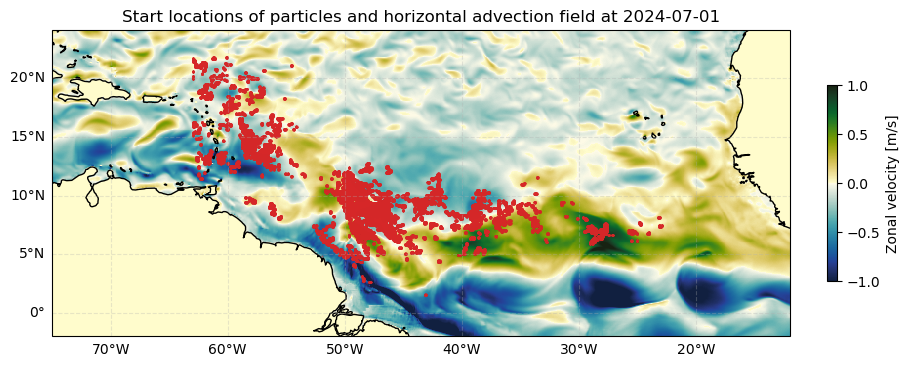

In [8]:
class SargassumParticle(parcels.JITParticle):
        temperature =   parcels.Variable('temperature', dtype=np.float32, to_write=True, initial=0)
        salinity    =   parcels.Variable('salinity', dtype=np.float32, to_write=True, initial=0)
        depth_extent =  parcels.Variable('depth_extent', dtype=np.float32, to_write=True, initial=1)
        nitrogen =      parcels.Variable('nitrogen', dtype=np.float32, to_write=True, initial=0)
        biomass_SF3 =    parcels.Variable('biomass_SF3', dtype=np.float32, to_write=True, initial=1)
        biomass_SN1 =    parcels.Variable('biomass_SN1', dtype=np.float32, to_write=True, initial=1)
        biomass_SN8 =    parcels.Variable('biomass_SN8', dtype=np.float32, to_write=True, initial=1)
        biomass_loss =   parcels.Variable('biomass_loss', dtype=np.float32, to_write=True, initial=0)
        stranded =      parcels.Variable('stranded', dtype=np.float32, to_write=True, initial=0)
        limitation =    parcels.Variable('limitation', dtype=np.float32, to_write=True, initial=1)
        lim_salinity =   parcels.Variable('lim_salinity', dtype=np.float32, to_write=True, initial=0)
        lim_temp    =    parcels.Variable('lim_temp', dtype=np.float32, to_write=True, initial=0)
        lim_no3     =    parcels.Variable('lim_no3', dtype=np.float32, to_write=True, initial=0)
        speed_currents = parcels.Variable('speed_currents', dtype=np.float32, to_write=True, initial=0)
        speed_stokes =   parcels.Variable('speed_stokes', dtype=np.float32, to_write=True, initial=0)
        speed_wind =     parcels.Variable('speed_wind', dtype=np.float32, to_write=True, initial=0)
        decay_factor =   parcels.Variable('decay_factor', dtype=np.float32, to_write=True, initial=0)
        decay_averaged = parcels.Variable('decay_averaged', dtype=np.float32, to_write=True, initial=0 )
        decay_integrated_lower = parcels.Variable('decay_integrated_lower', dtype=np.float32, to_write=True, initial=0 )
        decay_integrated_upper = parcels.Variable('decay_integrated_upper', dtype=np.float32, to_write=True, initial=0 )
        wind_coefficient = parcels.Variable('wind_coefficient', dtype=np.float32, to_write=True, initial=0.01) 

pset = parcels.ParticleSet.from_list(
     fieldset=fieldset,                      #Fieldsets on which the particles are advected
     pclass = SargassumParticle,             #Particle class
     lon = sarg_LONGITUDES,                  #Vector of release longitudes
     lat = sarg_LATITUDES,                   #Vector of release latitudes
     depth = np.zeros_like(sarg_LONGITUDES)  #Vector of release depths
     )

# nparticles = 4 * 4

# pset = parcels.ParticleSet.from_list(
#       fieldset=fieldset,  # the fields on which the particles are advected
#       pclass = SargassumParticle,
#       lon=[-43, -43, -40, -40, 
#            -20, -20, -17, -17,
#            -55, -55, -52, -52,
#            -23, -23, -20, -20], # a vector of release longitudes
      
#       lat=[2,  5,  2, 5,
#            -2, 1, -2, 1,
#            13, 16, 13, 16,
#            9, 12, 9, 12],       # a vector of release latitudes

#       depth=[0] * nparticles    # a vector of release depths
#   )


#Plotting velocity field of first timestep
fieldset.computeTimeChunk()
fig = plt.figure(figsize = (9,4), constrained_layout=True)
ax = plt.axes(projection=ccrs.PlateCarree())
vplot = ax.pcolormesh(fieldset.U.grid.lon, fieldset.U.grid.lat, fieldset.U.data[0, 0,:,:], vmin=-1, vmax=1, cmap=cmo.delta, transform=ccrs.PlateCarree())
lplot = ax.scatter(pset.lon, pset.lat, s =0.1, color='tab:red')
ax.add_feature(cartopy.feature.COASTLINE.with_scale('50m'))
ax.add_feature(cartopy.feature.LAND.with_scale('10m'))
ax.gridlines(draw_labels=['left','bottom'], zorder=0, alpha=0.3, linestyle='--')
ax.set_title(f'Start locations of particles and horizontal advection field at {starttime.date()}')
ax.set_extent([-75,-12, -2,21])
cbar = fig.colorbar(vplot, ax=ax, shrink = 0.5)
cbar.set_label('Zonal velocity [m/s]')
plt.show()

## Setting up the operational kernels to describe *Sargassum* behaviour

Kernels describe 'operations' that are performed on every particle at every timestep of the simulation. They allow. The kernels allow for behaviour of the particles. For transport by currents, we apply the build-in `AdvectionRK4` kernel, which is commonly used for 2D advection. For other processes, customized kernels were created which describe specific *Sargassum* raft behaviour. The following kernels :
1. `di_Stokes_drift`: Kernel for Stokes drift integrated between upper and lower extent of raft
2. `windage_drift`: Kernel for inclusion of leeway windage (relative)
3. `stranding`: Kernel that accounts for stranding 
4. `sargassum_biological_growth_model`: Kernel for calculation of relative biomass, dependent on temperature, nitrate availability and salinity. 

! Note that the `sargassum_biological_growth_model` requires certain growth model parameters regarding the limitation functions on growth by physico-chemical factors. To have them aligned with the first cell of this notebook, it should be checked if the values correspond. 

In [10]:
def di_Stokes_drift(particle, fieldset, time):
    """Depth-integrated Stokes drift kernel:

    Description
    ----------
    Using the approach in [1] (assuming a Phillips wave spectrum), equation A.6 and A.7 of [2] are used to determine
    the Stokes drift velocity integrated over depth between upper extent and lower extent of particle. 

    Stokes drift is treated as a linear addition to the velocity field. 

    Parameter Requirements
    ----------
    fieldset :
        - fieldset.U_wave_Stokes: zonal Stokes drift velocity at surface [m s-1]
        - fieldset.V_wave_Stokes: meridional Stokes drift velocity at surface [m s-1]
        - fieldset.wave_Tp: the peak wave period field [s].

    References
    ----------
    [1] Breivik (2016) - https://doi.org/10.1016/j.ocemod.2016.01.005
    [2] Li et al. (2017) - http://dx.doi.org/10.1016/j.ocemod.2017.03.016  
    """

    delta_z = particle.depth_extent - particle.depth
    z_up = particle.depth
    z_low = z_up + particle.depth_extent

    #Sampling the U / V components of Stokes drift at upper level
    stokes_U = fieldset.U_wave_Stokes[time, particle.depth, particle.lat, particle.lon]
    stokes_V = fieldset.V_wave_Stokes[time, particle.depth, particle.lat, particle.lon]

    #Sampling the peak wave period
    T_p = fieldset.wave_Tp[time, particle.depth, particle.lat, particle.lon]

    #Only computing displacements if the peak wave period is large enough and the particle is in the water
    if T_p > 1E-14: #and particle.depth < local_bathymetry:
        #Peak wave frequency
        omega_p = 2. * math.pi / T_p

        #Peak wave number
        k_p = (omega_p ** 2) / fieldset.G

        #Decay function lower extent, based on Equation A.6 of Li et al. (2017) 
        decay_function_lower = 1/(2*k_p) * ( 
                    1 - math.exp(-2.0*k_p*z_low) 
                    - (2.0/3.0) * (1 + math.sqrt(math.pi) * (2.0*k_p*z_low)**(3.0/2.0) * math.erfc(math.sqrt(2.0*k_p*z_low))  
                    - (1 + 2.0*k_p*z_low) * math.exp(-2.0*k_p*z_low)   )
                    )
        

        #Decay function upper extent, based on Equation A.6 of Li et al. (2017) 
        decay_function_upper = 1/(2*k_p) * ( 
                    1 - math.exp(-2.0*k_p*z_up) 
                    - (2.0/3.0) * (1 + math.sqrt(math.pi) * (2.0*k_p*z_up)**(3.0/2.0) * math.erfc(math.sqrt(2.0*k_p*z_up))  
                    - (1 + 2.0*k_p*z_up) * math.exp(-2.0*k_p*z_up)   )
                    )
        
        #Integration function between surface and lower level based on Equation A.7 of Li et al. (2017)
        stokes_U_integrated = (stokes_U * decay_function_lower - stokes_U * decay_function_upper) / delta_z
        stokes_V_integrated = (stokes_V * decay_function_lower - stokes_V * decay_function_upper) / delta_z

        #Saving lower and upper decay function and total Stokes decay factor as particle variables
        particle.decay_integrated_lower = decay_function_lower
        particle.decay_integrated_upper = decay_function_upper
        particle.decay_factor = (decay_function_lower - decay_function_upper) / delta_z

        #Compute particle displacement based on depth-integrated Stokes velocity
        particle_dlon += stokes_U_integrated  * particle.dt  
        particle_dlat += stokes_V_integrated  * particle.dt 

def windage_drift(particle, fieldset, time):
    """Leeway windage kernel.

    Description
    ----------
    A simple windage kernel that applies a linear relative 'wind velocity' to the particle. 
    Slightly adapted for the usage for Sargassum.

    We treat the windage drift as a linear addition to the velocity field
        :math:`u(x,t) = u_c(x,t) + C_w * (u_w(x,t)-u_c(x,t))`
    where :math:`u_c` is the ocean current velocity, :math:`u_w` is the wind velocity
    at 10m height, and :math:`C_w` is the windage coefficient.

    For further description, see https://plastic.parcels-code.org/en/latest/physicskernels.html#wind-induced-drift-leeway

    Parameter Requirements
    ----------
    particle :
        - wind_coefficient - the particle windage coefficient in decimals.
    fieldset :
        - `fieldset.Wind_U` and `fieldset.Wind_V`, the wind velocity field at 10m height above sea surface. Units [m s-1].

    Kernel Requirements
    ----------
    Order of Operations:
        None - can be applied at any time.

    """
    # Sample ocean velocities
    (ocean_U, ocean_V) = fieldset.UV[particle]
    ocean_speed = math.sqrt(ocean_U**2 + ocean_V**2)

    # Use a basic approach to only apply windage to particle in the ocean
    if ocean_speed > 1E-14:
        # Sample the U / V components of wind
        wind_U = fieldset.U_wind[time, particle.depth, particle.lat, particle.lon]
        wind_V = fieldset.V_wind[time, particle.depth, particle.lat, particle.lon]

        # Compute particle displacement
        particle_dlon += particle.wind_coefficient * (wind_U - ocean_U) * particle.dt  # noqa
        particle_dlat += particle.wind_coefficient * (wind_V - ocean_V) * particle.dt  # noqa

def stranding(particle, fieldset, time): 
    """Data-based stranding kernel.

    Description
    ----------
    Kernel that determines if a particle is stranded under the condition that U or V == 0. 
    When a particle is stranded, tt also makes sure that physical transport is set to 0 (so no updates of particles' dlon and dlat) 
  
    Parameter Requirements
    ----------
    particle :
        - stranded - initially 0, and becomes 1 when stranded.
    fieldset :
        - `fieldset.U` and `fieldset.V`, the wind velocity field at 10m height above sea surface. Units [m s-1].

    Kernel Requirements
    ----------
    Order of Operations:
        At the end of physical kernels. Otherwise dlon and dlat will be updated again.

    """

    u = fieldset.U[time, particle.depth, particle.lat, particle.lon]
    v = fieldset.V[time, particle.depth, particle.lat, particle.lon]

    if u == 0.0 or v == 0.0:
        particle.stranded = 1
    
    if particle.stranded == 1:
        particle_dlon = 0.0
        particle_dlat = 0.0






#Kernel that determines the new weight of the particle 
#Based on the maximum growth rates of morphotypes and multiple limitation curves
def sargassum_biological_growth_model(particle, fieldset, time): 

    #We start by sampling temperature field, salinity field and nitrogen field at particle location
    particle.temperature =  fieldset.T[time, particle.depth, particle.lat, particle.lon]
    particle.salinity =     fieldset.S[time, particle.depth, particle.lat, particle.lon]
    
    #Selecting depth at which nitrogen field is defined
    # = particle.depth
    #if z_for_n <= 0.49402538:
    
    z_for_n = 0.49402538
    particle.nitrogen =     fieldset.no3[time, z_for_n, particle.lat, particle.lon] 

    #RATES
    maximum_growth_rate = 0.095 #doublings/day
    mortality_rate = 0.02     #relative loss/day

    #Minimum, maximum and optimal temperature 
    T_min = 20      #degC
    T_max = 31      #degC
    T_opt = 27.5    #degC

    #Nitrogen half saturation constant
    k_N  = 0.001 #mmol/m3

    #Optimal salinity
    S_opt = 36 #psu

    #GROWTH LIMITATION FUNCTION DEPENDENT ON TEMPERATURE
    #Formulation from Jouanno et al. (2025).
    if particle.temperature < T_opt:
        limitation_factor_T = math.exp(-2 * ( (particle.temperature - T_opt)/ (T_min - T_opt))**2 )
    else:
        limitation_factor_T = math.exp(-2 * ( (particle.temperature - T_opt)/ (T_max - T_opt))**2 )

    #GROWTH LIMITATION FUNCTION DEPENDENT ON NITROGEN AVAILABILTIY
    #Formulation from Bonner et al. (2024)
    limitation_factor_N = particle.nitrogen / ( k_N + particle.nitrogen )

    #GROWTH LIMITATION FUNCTION DEPENDENT ON SALINITY
    #Formula from Jouanno et al. (2025)
    limitation_factor_S = math.exp(-0.02 * (S_opt - particle.salinity)**2 )

    ###################################

    #Save particle total limitation an seperate limitations as variables
    LIMITATION = limitation_factor_T * limitation_factor_N * limitation_factor_S
    particle.limitation = LIMITATION
    particle.lim_salinity = limitation_factor_S
    particle.lim_temp = limitation_factor_T
    particle.lim_no3 = limitation_factor_N

    #UPDATE OF PARTICLE WEIGHT with maximum specific growth rate and mortality rate converted from day-1 to s-1
    #If particle is stranded, biomass is not updated. 
    #mortality_rate = 0.025 #loss/day

    if particle.stranded == 1 :
        particle.biomass_SF3 = particle.biomass_SF3

    else:
        particle.biomass_SF3 *= 2 ** ((LIMITATION * (maximum_growth_rate / (24*60*60)) - mortality_rate / (24*60*60) ) * particle.dt ) 
        particle.biomass_loss = particle.biomass_SN1 - particle.biomass_SF3

## Executing the simulation

Now, we create an output particle file (`pfile`) and add all the `kernels` that we want to be executed during the simulation, which are formulated in the previous code. At last, we `execute` the simulation based on the satellite-based particle set (`pset`). In the execution step, the total `runtime` of the simulation is determined. It is by default set at 30 days but can be changed as prefered. The timestep of the execution (`dt`) at which the kernels are executed, should not be changed. 

**! Running this step will take approximately up to 30 minutes**

In [11]:
##################################################################################################
#Creating output particle file
pfile = pset.ParticleFile('Sargassum_simulation',       #file name
    outputdt=timedelta(hours=2),                        #time step of the output
    chunks = (sarg_AMOUNT, 50))                         #between how many timesteps data is saved

##################################################################################################
#Importing file in which kernels are defined
import CUSTOM_KERNELS as ck

#Selecting kernels 
kernels = [parcels.AdvectionRK4, di_Stokes_drift, windage_drift]        #physical kernels

kernels+= [sargassum_biological_growth_model]                           #biological kernel

kernels+= [stranding]                                                   #other kernels

##################################################################################################
#Executing the simulation
pset.execute(
    kernels,                                    #the kernels (which define how particles move)
    runtime=timedelta(days=simulation_days),    #the total runtime of the simulation
    dt=dtime_execute,                           #the timestep of the kernel executions
    output_file=pfile)                          #the output file as defined above
##################################################################################################

/nethome/6903894/parcels_env/lib/python3.13/site-packages/parcels/field.py:1180: RuntimeWarning: Sampling of velocities should normally be done using fieldset.UV or fieldset.UVW object; tread carefully
  self._check_velocitysampling()


INFO: Output files are stored in Sargassum_simulation.zarr.
100%|██████████| 2592000.0/2592000.0 [23:44<00:00, 1819.40it/s]


## Exploring and visualizing the output

In this part, we investigate the zarr data file created in the previous step and visualize the output in various ways. 

We start by opening the dataset to see what the dimensions, variables and other attributes are. 

In [12]:
Path_to_output = "/nethome/6903894/testing/Sargassum_simulation.zarr"
Output_trajectory_dataset = xr.open_zarr(Path_to_output).dropna(dim='obs', how='all')

Output_trajectory_dataset

<xarray.Dataset> Size: 4GB
Dimensions:                 (trajectory: 103614, obs: 360)
Coordinates:
  * obs                     (obs) int32 1kB 0 1 2 3 4 5 ... 355 356 357 358 359
  * trajectory              (trajectory) int64 829kB 0 1 2 ... 103612 103613
Data variables: (12/25)
    biomass_SF3             (trajectory, obs) float32 149MB dask.array<chunksize=(103614, 50), meta=np.ndarray>
    biomass_SN1             (trajectory, obs) float32 149MB dask.array<chunksize=(103614, 50), meta=np.ndarray>
    biomass_SN8             (trajectory, obs) float32 149MB dask.array<chunksize=(103614, 50), meta=np.ndarray>
    biomass_loss            (trajectory, obs) float32 149MB dask.array<chunksize=(103614, 50), meta=np.ndarray>
    decay_averaged          (trajectory, obs) float32 149MB dask.array<chunksize=(103614, 50), meta=np.ndarray>
    decay_factor            (trajectory, obs) float32 149MB dask.array<chunksize=(103614, 50), meta=np.ndarray>
    ...                      ...
    speed_wind              (trajectory, obs) float32 149MB dask.array<chunksize=(103614, 50), meta=np.ndarray>
    stranded                (trajectory, obs) float32 149MB dask.array<chunksize=(103614, 50), meta=np.ndarray>
    temperature             (trajectory, obs) float32 149MB dask.array<chunksize=(103614, 50), meta=np.ndarray>
    time                    (trajectory, obs) datetime64[ns] 298MB dask.array<chunksize=(103614, 50), meta=np.ndarray>
    wind_coefficient        (trajectory, obs) float32 149MB dask.array<chunksize=(103614, 50), meta=np.ndarray>
    z                       (trajectory, obs) float64 298MB dask.array<chunksize=(103614, 50), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        SargassumParticleAdvectionRK4di_Stokes_driftwinda...
    parcels_mesh:           spherical
    parcels_version:        3.1.2

The following `biomass_plot` function is made to plot the final relative biomass of each particle and to explore the spatial variation and distribution. It can be chosen to plot it on the initial starting location (`FINAL=False`), and see how much particles will grow. Or it can be chosen to plot or the final location (`FINAL=True`) to see the distribution and relative biomass after the transport and growth. 

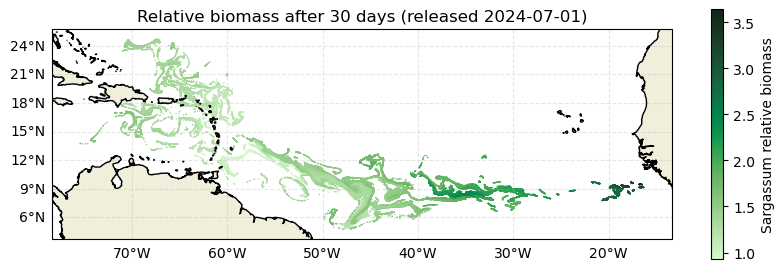

In [13]:
def biomass_plot(DATA, COLORMAP, STARTTIME, FINAL=True):

    #FIGURE
    fig = plt.figure(figsize = (10,5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.gridlines(draw_labels=['left','bottom'], zorder=2, alpha=0.3, linestyle='--')

    if FINAL == True:
        cscat = ax.scatter(DATA.lon[:,-1], DATA.lat[:,-1], c = DATA.biomass_SF3[:,-1].values,
        cmap=COLORMAP, s=1, linewidth=0, transform=ccrs.PlateCarree(), zorder=1)
    else:
    #Colored scatter plot with STARTING lon, lat and FINAL values of the categorized weight
        cscat = ax.scatter(DATA.lon[:,0], DATA.lat[:,0], c = DATA.biomass_SF3[:,-1].values,
        cmap=COLORMAP, s=2, linewidth=0, transform=ccrs.PlateCarree(), zorder=1)

    #Other figure settings
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('10m'), zorder=2)
    ax.add_feature(cartopy.feature.LAND.with_scale('10m'))
    if FINAL == True:
        ax.set_title(f'Relative biomass after {simulation_days} days (released {STARTTIME.date()})')
    else:
       ax.set_title(f'Potential biomass after {simulation_days} days, plotted at initial location (released {STARTTIME.date()})')

    plt.colorbar(cscat, ax=ax, orientation='vertical', label='Sargassum relative biomass', shrink=0.65)

    return plt.show()

biomass_plot(Output_trajectory_dataset, cmo.algae, starttime, FINAL=True)

In the following piece of code, the total growth factor and seperate growth factors of temperature, nitrate availability and salinity are averaged of time for each trajectory. These time-averaged growth factors are then visualized in a boxplot to compare their relative importance in constraining growth.

Type of data for boxplot:  <class 'list'>  with shape:  (4, 103614)


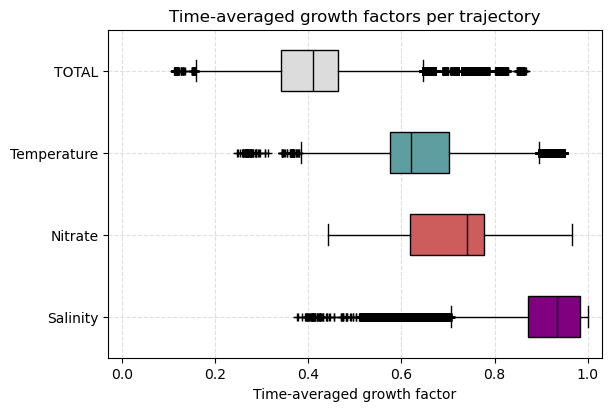

In [14]:
#Calculating mean over time of limitation values 
timemean_lim_sal =    Output_trajectory_dataset['lim_salinity'].mean(dim='obs')      
timemean_lim_temp =   Output_trajectory_dataset['lim_temp'].mean(dim='obs')       
timemean_lim_no3 =    Output_trajectory_dataset['lim_no3'].mean(dim='obs')          
timemean_lim_tot =    Output_trajectory_dataset['limitation'].mean(dim='obs')   

boxplot_list = [timemean_lim_sal[:], timemean_lim_no3[:], timemean_lim_temp[:], timemean_lim_tot[:]] 
print('Type of data for boxplot: ', type(boxplot_list), ' with shape: ', np.shape(boxplot_list))
      
limitation_names = ['Salinity', 'Nitrate', 'Temperature', 'TOTAL']
colors = ['purple' , 'indianred', 'cadetblue', 'gainsboro']

#Positions for each month
positions = np.arange(len(limitation_names)) 

plt.figure(figsize=(6,4), constrained_layout=True)

#Boxplots with different colors
for i, data in enumerate(boxplot_list):
    plt.boxplot(
        data,
        positions=[positions[i]],
        widths=0.5,
        patch_artist=True,
        orientation='horizontal',
        boxprops=dict(facecolor=colors[i]),
        medianprops=dict(color='black'),
        sym='+'
    )

plt.yticks(positions , limitation_names, rotation=0)
plt.xlabel('Time-averaged growth factor')
plt.title(f'Time-averaged growth factors per trajectory')
plt.xlim(-0.03,1.03)
plt.grid( linestyle='--', alpha=0.4)
plt.show()

The code in the following shows how many particles strand during the simulation. 

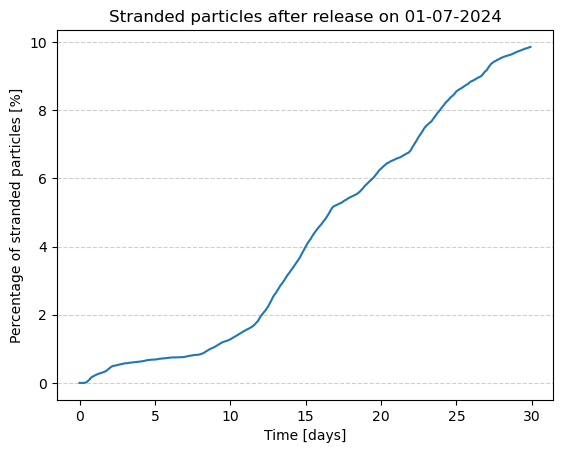

Final amount of stranded particles is:  10218.0 particles. This corresponds to  9.861602 %


In [15]:
DS = Output_trajectory_dataset

#Defining a time array in days
time_in_days = ((DS['time'] - DS['time'][:, 0]).astype("timedelta64[h]")).astype(float) / 24

#Summing the amount of stranded particles over trajectories for each time step
stranded_sum = np.sum(Output_trajectory_dataset.stranded[:, :], axis=0)

#Calculating the percentage of stranded particles relative to total amount of released particles
n_traj = len(DS.trajectory)
stranded_percentage = 100 * stranded_sum / n_traj

#Plotting over time in figure
fig, ax = plt.subplots()
ax.plot(time_in_days[0, :],stranded_percentage)
ax.set_xlabel('Time [days]')
ax.set_ylabel('Percentage of stranded particles [%]')
ax.set_title('Stranded particles after release on 01-07-2024')
ax.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

print('Final amount of stranded particles is: ', stranded_sum[-1].values, 'particles. This corresponds to ', stranded_percentage[-1].values, "%")

## References

Bonner, G., Beron-Vera, F. J., & Olascoaga, M. J. (2024). Charting the course of Sargassum: Incorporating nonlinear elastic interactions and life cycles in the Maxey–Riley model. PNAS nexus, 3(10), pgae451.

Hanisak, M. D., & Samuel, M. A. (1987, September). Growth rates in culture of several species of Sargassum from Florida, USA. In Twelfth International Seaweed Symposium: Proceedings of the Twelfth International Seaweed Symposium held in Sao Paulo, Brazil, July 27–August 1, 1986 (pp. 399-404). Dordrecht: Springer Netherlands.

Hu, C., Zhang, S., Barnes, B. B., Xie, Y., Wang, M., Cannizzaro, J. P., & English, D. C. (2023). Mapping and quantifying pelagic Sargassum in the Atlantic Ocean using multi-band medium-resolution satellite data and deep learning. Remote sensing of environment, 289, 113515.

Jouanno, J., Berthet, S., Muller-Karger, F., Aumont, O., & Sheinbaum, J. (2025). An extreme North Atlantic Oscillation event drove the pelagic Sargassum tipping point. Communications Earth & Environment, 6(1), 95.

Magaña-Gallegos, E., García-Sánchez, M., Graham, C., Olivos-Ortiz, A., Siuda, A. N., & van Tussenbroek, B. I. (2023). Growth rates of pelagic Sargassum species in the Mexican Caribbean. Aquatic Botany, 185, 103614.
